## EM algorithm



In [1]:
using LinearAlgebra
using Plots
using Random
using Distributions
import SpecialFunctions.digamma, SpecialFunctions.gamma

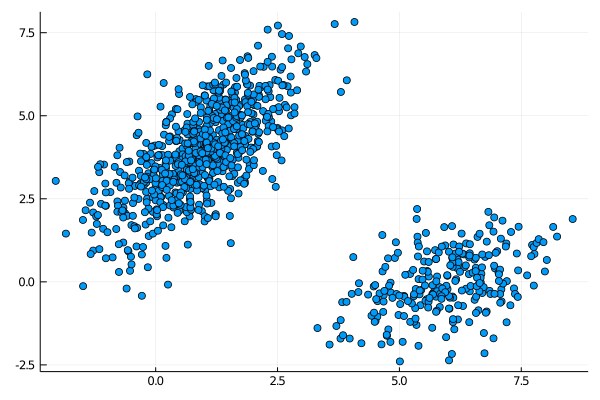

In [2]:
mu1  = [6.,0.]; sig1 = [1. 0.5;0.5 1.];
mu2  = [1.,4.]; sig2 = [1. 1.;1. 2.];
π1 = 0.25;
π2 = 1 - π1;

# Target distribution
GM = MixtureModel(MvNormal, [(mu1, sig1), (mu2, sig2)], [π1, π2]);
data = rand(GM, 1000);
plot(data[1,:], data[2,:], seriestype=:scatter, leg=false)

In [3]:
function VBEstep(X, α, β, m, W, ν)
    E_lnπ = digamma.(α) .- digamma(sum(α)); # prml (10.66)
    E_lnΛ = zeros(K);
    for k in 1:K
        # prml (10.65)
        E_lnΛ[k] = sum(digamma.(0.5(ν[k].+collect(1:D) .- 1))) + D*log(2) + logdet(W[:, :, k]);  
    end

    ln_ρ = zeros(N, K);
    for n in 1:N
        for k in 1:K
            EμΛ = D/β[k] + ν[k]*(X[:, n] - m[:, k])'*W[:, :, k]*(X[:, n] - m[:, k]);  # prml (10.67)
            ln_ρ[n, k] = E_lnπ[k] + 0.5(E_lnΛ[k] - D*log(2pi) - EμΛ);  # prml (10.46)
        end
    end
    r = exp.(ln_ρ .- log.(sum(exp.(ln_ρ), dims=2)));  # prml (10.49)
    return r
end

VBEstep (generic function with 1 method)

In [4]:
function VBMstep(X, r)
    Nk = sum(r, dims=1);  # prml (10.51)
    x_ = X*r./Nk;  # prml (10.52)

    # prml (10.53)
    S = zeros(D, D, K)
    for k in 1:K
        S[:, :, k] = sum([r[n, k] * (X[:, n] - x_[:, k]) * (X[:, n] - x_[:, k])' for n=1:N])/Nk[k]
    end
    
    α = α0 .+ Nk  # prml (10.58)
    β = β0 .+ Nk;  # prml (10.60)
    m = (β0*m0 .+ Nk.*x_)./β  # prml (10.61)
    
    # prml (10.63)
    W = zeros(D, D, K)
    for k in 1:K
        W[:, :, k] = inv(inv(W0) + Nk[k].*S[:, :, k] + (β0*Nk[k]/(β0 + Nk[k])) .* (x_[:, k] - m0)*(x_[:, k] - m0)')
    end
    ν = ν0 .+ Nk  # prml (10.63)
    return α[1, :], β[1, :], m, W, ν[1, :]
end

VBMstep (generic function with 1 method)

In [5]:
N_n_dim(x, mu, l) = 1/((2pi)^(size(x, 1)/2)) * det(inv(l))^(-1/2) * exp(-0.5(x - mu)'*l*(x - mu));
N_mix(x, mu, l, π) = sum([π[k] * N_n_dim(x, mu[:, k], l[:, :, k]) for k=1:size(π, 1)]);

In [6]:
function plot3fig(ii, Pii, Eπii, mii)
    ran = collect(-2.5:0.1:10);
    plt1 = contour(ran, ran, 
        (x, y) -> N_mix([x, y], [mu1 mu2], cat(inv(sig1), inv(sig2), dims=3), [π1, π2]), 
        title="real distribution",
        xlims = (-5,12),
        ylims = (-5,12),
        colorbar=false,
        aspect_ratio=:equal);
    
    plt2 = contour(ran, ran, 
        (x, y)->Pii([x, y]),
        title="VBEM $ii step(s)",
        xlims = (-5,12),
        ylims = (-5,12),
        colorbar=false,
        aspect_ratio=:equal);
    
    plt3 = scatter(mii[1, :], mii[2, :], 
        markersize=30*log.(Eπii[:].+1),
        alpha=0.5,
        title="E[μ]",
        xlims = (-5,12),
        ylims = (-5,12),
        aspect_ratio=:equal)
    
    return plot(plt1, plt2, plt3, layout=(1, 3), leg=false);
end

plot3fig (generic function with 1 method)

In [24]:
D, N = size(data);
K = 10;

# initial prior parameters
## Dirichlet
α0 = 1/K;
α_ = ones(K) * α0;

## Gauss-Wishart
β0 = 1.;
β_ = ones(K) * β0;

# m0 = mean(data, dims=2);
m0 = zeros(D)
m_ = data[:, rand(1:N, K)]  # random cohice from data as initial m, this is better than below way for prediction.
# m_ = rand(min(data...):0.01:max(data...), 2, K);  # not good way to choose initial values, just for visualization.

W0 = Matrix(I, D, D);
W_ = zeros(D, D, K);
W_ .= W0;

ν0 = D;
ν_ = ones(K)*ν0;


# initial Expected values of parameters
Eπ = ones(K)/K;
EΛ = zeros(D, D, K);
EΛ .= W0;

┌ Info: Saved animation to 
│   fn = /home/lee/projects/statistics/notebooks/VBEM1.gif
└ @ Plots /home/lee/.julia/packages/Plots/Xnzc7/src/animation.jl:104


Plots.AnimatedGif("/home/lee/projects/statistics/notebooks/VBEM1.gif")
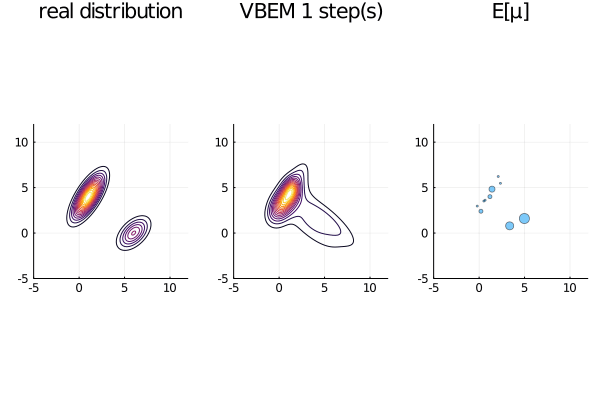

In [29]:
anim = Animation()

iter_n = 120;
params = (α_, β_, m_, W_, ν_);  # set initial parameters
for ii in 1:iter_n
    # VBEM
    r = VBEstep(data, params...)
    params = VBMstep(data, r)
    
    # 
    _, _, m, W, ν = params
    Eπ = (α0 .+ sum(r, dims=1)) ./ (K*α0 + N);  # prml (10.69)
    EΛ = W .* reshape(ν, 1, 1, K);  # prml (B.80)
    P_model(x) = N_mix(x, m, EΛ, Eπ[:]);
   
    if ii < 10 || ii%10==0
        frame(anim, plot3fig(ii, P_model, Eπ, m));
    end
end
gif(anim, "VBEM1.gif", fps = 1)